In [55]:
import time
import numpy as np
import scipy.optimize as opt
import tifffile
import multiprocessing
import ctypes
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [56]:
def block_bmd(start, end, dset, dset_shape, out, out_shape):
    
    # This part should be modified according to the setup and materials:
    M_water = np.array([0.3222, 0.3220, 0.2911, 0.2635, 0.2442, 0.2304, 0.2186, 0.2049]).reshape(-1,1)
    M_I = np.array([15.6188, 12.7954, 20.3665, 20.9604, 16.4106, 13.1529, 10.4335, 7.4192]).reshape(-1,1)
    M_Ba = np.array([15.1741, 12.5767, 9.4394, 19.2138, 18.2928, 14.7074, 11.6919, 8.3326]).reshape(-1,1)
    M_Gd = np.array([13.1257, 13.8609, 10.7791, 7.8003, 5.8833, 7.6278, 14.7015, 11.5078]).reshape(-1,1)

    M = np.concatenate((M_water, M_Ba, M_I, M_Gd), axis=1)

    # Get shared memory as numpy array:
    dset_np = np.frombuffer(dset, dtype=np.float32).reshape(dset_shape)
    out_np = np.frombuffer(out, dtype=np.float32).reshape(out_shape)

    # For each image element (pixel or voxel):
    for i in range(start, end + 1):  

        # Decompose:
        out_np[i,:] = opt.nnls(M, dset_np[i,:])[0]

In [57]:
def bmd(im, px_size, threads=16):

    # Remember shape:
    dims = im.shape    

    # Get the dimensions "flattened" except the last one:
    im = np.reshape(im, (np.prod(dims[0:-1]),dims[-1])) / px_size

    # Prepare shared memory:
    dset_shape = (im.shape[0],im.shape[1])
    dset = multiprocessing.RawArray(ctypes.c_float, im.shape[0] * im.shape[1])

    dset_np = np.frombuffer(dset, dtype=np.float32).reshape(dset_shape)	
    np.copyto(dset_np, im.astype(np.float32))

    # Prepare output:
    out_shape = (im.shape[0],4)
    out = multiprocessing.RawArray(ctypes.c_float, im.shape[0] * 4)

    # Array of jobs:
    jobs = []

    # Run several processes for independent computation on CPU:
    for i in range(threads):

        start = int((im.shape[0] / threads) * i)
        if (i == threads - 1):
            end = im.shape[0] - 1
        else:
            end = int((im.shape[0] / threads)) * (i + 1) - 1

        p = multiprocessing.Process(target=block_bmd, args=(start, end, dset, dset_shape, out, out_shape))
        jobs.append(p)
        p.start()

    # Wait for processes completion:
    for job in jobs:
        job.join()


    # Wrap shared memory as an numpy array:
    out_np = np.frombuffer(out, dtype=np.float32).reshape(out_shape)

    # Reshape output:
    water = np.reshape(out_np[:,0], dims[0:-1])    
    Ba = np.reshape(out_np[:,1], dims[0:-1])
    I = np.reshape(out_np[:,2], dims[0:-1])
    Gd = np.reshape(out_np[:,3], dims[0:-1])


    # Return
    return water, Ba, I, Gd

Elapsed time: 0.15904617309570312 s.


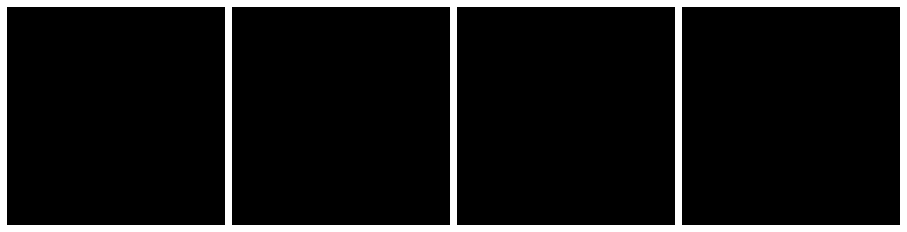

In [58]:
if __name__ == "__main__":

    IN_PATH = r".\data"
    OUT_PATH = r".\results"
    
    n_bins  = 8
    n_slice = 194 
    px_size = 0.0453

    # Read first image to get dims:
    im = tifffile.imread(IN_PATH + r"\bin1_slice" + str(n_slice).zfill(4) + ".tif")
    v = np.zeros((im.shape[0],im.shape[1],n_bins)).astype(np.float32)

    # Load all the bins:
    for i in range(n_bins):
        v[:,:,i] = tifffile.imread(IN_PATH + r"\bin" + str(i + 1) + "_slice" + str(n_slice).zfill(4) + ".tif")

    # Perform decomposition:
    t1 = time.time()
    water, Ba, I, Gd = bmd(v, px_size)
    t2 = time.time()

    # Display result and computational time:
    print("Elapsed time: " + str(t2-t1) + " s.")
        
    fig = plt.figure(figsize=(16., 16.))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.1)
    grid[0].imshow(water, cmap='gray', vmin=0, vmax=4.0)
    grid[1].imshow(Ba, cmap='gray', vmin=0, vmax=0.05)
    grid[2].imshow(I, cmap='gray', vmin=0, vmax=0.05)
    grid[3].imshow(Gd, cmap='gray', vmin=0, vmax=0.05)
    plt.show()
    
    # Write output:
    tifffile.imwrite(OUT_PATH + r"\water_slice" + str(n_slice).zfill(4) + ".tif", water.astype(np.float32))
    tifffile.imwrite(OUT_PATH + r"\Ba_slice" + str(n_slice).zfill(4) + ".tif", Ba.astype(np.float32))
    tifffile.imwrite(OUT_PATH + r"\I_slice" + str(n_slice).zfill(4) + ".tif", I.astype(np.float32))
    tifffile.imwrite(OUT_PATH + r"\Gd_slice" + str(n_slice).zfill(4) + ".tif", Gd.astype(np.float32))
